In [1]:
from zoish.feature_selectors.gridshap import GridSearchCVShapFeatureSelector
import xgboost
import logging
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<Figure size 432x288 with 0 Axes>

# Example 1 : Use Adult Data Set (a classification problem)
  
https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names=["age", "workclass", "fnlwgt" , "education" ,"education-num",
"marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week",
"native-country","label"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Define labels


In [3]:
data.loc[data['label']=='<=50K','label']=0
data.loc[data['label']==' <=50K','label']=0

data.loc[data['label']=='>50K','label']=1
data.loc[data['label']==' >50K','label']=1

data['label']=data['label'].astype(int)

# Train test split

In [4]:
X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, stratify=y['label'], random_state=42)


# Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


# Define Feature selector and set it argumens 

In [6]:
grid_classification_xgb = GridSearchCVShapFeatureSelector(
        # general argument setting        
        verbose=5,
        random_state=0,
        logging_basicConfig = None,
        # general argument setting        
        n_features=4,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=xgboost.XGBClassifier(),
        estimator_params={
        "max_depth": [4, 5],
        "min_child_weight": [0.1, 0.9],
        "gamma": [1, 9],
        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=True,
        save_shap_summary_plot=False,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## optuna params
        performance_metric = 'f1',
        cv = StratifiedKFold(n_splits=3, shuffle=True),

)


root - INFO - Setting value for logging_basicConfig
root - INFO - Getting value for logging_basicConfig
root - INFO - Setting value for verbose
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, mi

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline

In [7]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_XGBCLS_OPTUNA', grid_classification_xgb),
            # classification model
            ('logistic', LogisticRegression())


 ])



# Run Pipeline

root - INFO - Getting value for estimator
root - INFO - Getting value for estimator_params
root - INFO - Getting value for performance metric
root - INFO - Getting value for verbose
root - INFO - Getting value for grid_search_n_jobs
root - INFO - Getting value for cv


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=0.699 total time=   0.6s
[CV 2/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=0.719 total time=   1.8s
[CV 3/3] END gamma=1, max_depth=4, min_child_weight=0.1;, score=0.703 total time=   0.7s
[CV 1/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=0.697 total time=   0.8s
[CV 2/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=0.721 total time=   0.4s
[CV 3/3] END gamma=1, max_depth=4, min_child_weight=0.9;, score=0.703 total time=   0.5s
[CV 1/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=0.694 total time=   0.6s
[CV 2/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=0.715 total time=   0.5s
[CV 3/3] END gamma=1, max_depth=5, min_child_weight=0.1;, score=0.699 total time=   0.5s
[CV 1/3] END gamma=1, max_depth=5, min_child_weight=0.9;, score=0.690 total time=   0.5s
[CV 2/3] END gamma=1, max_depth=5, min_child_weigh

root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


XGBClassifier


 97%|=================== | 21091/21815 [00:21<00:00]       root - INFO - Getting value for plot shap summary
root - INFO - Getting value for n_features


.values =
array([[-1.42574722e+00,  4.06478774e-02,  1.48894635e-02, ...,
        -4.58582347e-02, -4.68087296e-03,  1.07961993e-02],
       [-5.14915109e-01,  3.70763099e-02, -2.74058589e-02, ...,
        -3.84414321e-02,  1.10318474e-02,  2.10819716e-03],
       [ 4.88015881e-01,  5.53512043e-02, -3.68114800e-01, ...,
        -4.44824963e-02,  4.81396552e-02,  4.04144551e-03],
       ...,
       [ 9.65909177e-01,  5.44612583e-02, -3.97326759e-01, ...,
        -3.11386082e-02,  4.73399994e-01, -3.29791401e-04],
       [-5.63892462e-01,  9.07221437e-02, -5.29938510e-01, ...,
        -3.48264714e-02,  7.71458882e-01,  5.60798276e-03],
       [-1.63414206e+00,  3.51466806e-02,  3.64304803e-01, ...,
        -4.07153452e-02, -3.14071163e-02, -1.97821579e-03]])

.base_values =
array([-2.62909736, -2.62909736, -2.62909736, ..., -2.62909736,
       -2.62909736, -2.62909736])

.data =
array([[    24,      1, 228649, ...,      0,     38,      1],
       [    28,      1, 122540, ...,      0,    

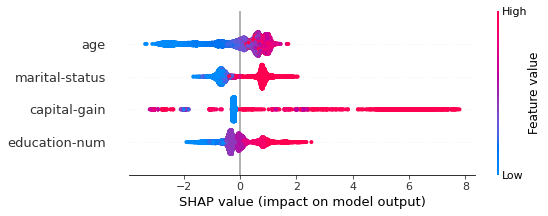

root - INFO - Getting value for save_shap_summary_plot
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df


                 0         1
0              age   0.83314
1        workclass  0.083551
2           fnlwgt  0.133169
3        education  0.044487
4    education-num  0.472467
5   marital-status   0.72843
6       occupation  0.375385
7     relationship  0.392759
8             race  0.057074
9              sex   0.17918
10    capital-gain  0.535238
11    capital-loss    0.1272
12  hours-per-week  0.412555
13  native-country   0.02786
       column_name shap_importance
0              age         0.83314
1        workclass        0.083551
2           fnlwgt        0.133169
3        education        0.044487
4    education-num        0.472467
5   marital-status         0.72843
6       occupation        0.375385
7     relationship        0.392759
8             race        0.057074
9              sex         0.17918
10    capital-gain        0.535238
11    capital-loss          0.1272
12  hours-per-week        0.412555
13  native-country         0.02786
       column_name shap_importance
0    

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [8]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [9]:
print('F1 score : ')
print(f1_score(y_test,y_pred))
print('Classification report : ')
print(classification_report(y_test,y_pred))
print('Confusion matrix : ')
print(confusion_matrix(y_test,y_pred))


F1 score : 
0.6111595466434175
Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      8158
           1       0.70      0.54      0.61      2588

    accuracy                           0.83     10746
   macro avg       0.78      0.73      0.75     10746
weighted avg       0.83      0.83      0.83     10746

Confusion matrix : 
[[7560  598]
 [1186 1402]]
